In [1]:
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-cp36-none-any.whl size=7099 sha256=3b98e0ce5a0907fe3258ec115a8f8f9e3dc526a68fdacac4b5ad6dcf531ecb02
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


In [2]:
# Data from here:
# https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from adjustText import adjust_text
from matplotlib.ticker import ScalarFormatter

# READ CUMULATIVE TABLE
covid_cumulative = pd.read_excel("covid_a_master_cumulative_table.xlsx")

## FILTER THE LAST DAY OF THE RESULTS AND PICK THE TOP N IN # OF CASES

In [3]:
# This part is necessary instead of simply ['Date'].max() because some countries do not report on certain days (e.g. Spain on Sundays) -- FIXED BUG
last_day_per_country = covid_cumulative.groupby(by=['Countries'])['Date'].max() # type(last_day_per_country) is pandas.Series
last_day_per_country = last_day_per_country.to_frame() # We convert it to pandas.DataFrame
last_day_per_country.reset_index(inplace=True) # And reset the index so that we can further join on 'Countries'

In [4]:
# N: HOW MANY TOP COUNTRIES YOU WANT TO PICK IN TERMS OF # OF CASES
N = 25
last_day = pd.merge(covid_cumulative, last_day_per_country, how='inner', left_on = ['Countries', 'Date'], right_on = ['Countries', 'Date'])
last_day = last_day.sort_values('Cases', ascending=False)
top_countries = last_day[:N]['Countries'].tolist()

## FURTHER FILTER THE TOP N COUNTRIES WITH >K CASES


In [5]:
# K: HOW MANY CASES YOU CONSIDER THE DAY 0
K = 100
covid_top_countries = covid_cumulative[covid_cumulative.Countries.isin(top_countries)]
covid_top_countries = covid_top_countries[covid_top_countries['Cases'] > K]

In [6]:
# FIND THE DATE THAT THE FIRST K CASES WERE IDENTIFIED
day_0_for_every_country = covid_top_countries.groupby(by=['Countries']).min()
day_0_for_every_country = day_0_for_every_country['Date']

In [7]:
# MERGE THE TWO TO GET THE DAY_0 IN THE df, AND CALCULATE THE DAYS_FROM_0
covid_top_countries = covid_top_countries.merge(day_0_for_every_country, how='inner', on='Countries')
covid_top_countries.rename(columns = {'Date_y': 'Day_0'}, inplace = True)
covid_top_countries['Days_from_0'] = (covid_top_countries['Date_x'] - covid_top_countries['Day_0']).dt.days
# covid_top_countries = covid_top_countries[covid_top_countries['Days_from_0']<150]

In [8]:
#Adding the Infection rate per 1M column to the covid_top_countries dataframe
covid_top_countries['Cases_per_1m'] = covid_top_countries['Cases']/covid_top_countries['Population']* 1000000

### CREATE THE MAX_CASES DF TO USE IT IN LABELING THE GRAPHS

In [12]:
#For labelling in the graph
max_cases = covid_top_countries.groupby(by=['Countries']).max()
max_cases['Case_fatality_rate'] = max_cases['Deaths']/max_cases['Cases']*100
max_cases.sort_values('Cases', ascending=False)
max_cases['Infection_rate_per_1m'] = max_cases['Cases']/max_cases['Population']*1000000
max_cases['Mortality_rate_per_1m'] = max_cases['Deaths']/max_cases['Population']*1000000
max_cases.drop('Unnamed: 0', axis = 1, inplace = True)
max_cases.to_excel('covid_b_max_cases.xlsx')

In [13]:
#Sorting the data countries wise according to infection rate per 1M
covid_top_countries.index.name = None
max_slope = covid_top_countries.groupby(by=['Countries']).max()
max_slope = max_slope.sort_values('Cases_per_1m', ascending=False)
max_slope['Countries'] = max_slope.index

data_1_5 = covid_top_countries[covid_top_countries.Countries.isin(max_slope[:5]['Countries'].tolist())]
countries_1_5 = max_slope[:5]['Countries'].tolist()
data_6_10 = covid_top_countries[covid_top_countries.Countries.isin(max_slope[5:10]['Countries'].tolist())]
countries_6_10 = max_slope[5:10]['Countries'].tolist()
data_11_15 = covid_top_countries[covid_top_countries.Countries.isin(max_slope[10:15]['Countries'].tolist())]
countries_11_15 = max_slope[10:15]['Countries'].tolist()
data_16_20 = covid_top_countries[covid_top_countries.Countries.isin(max_slope[15:20]['Countries'].tolist())]
countries_16_20 = max_slope[15:20]['Countries'].tolist()
max_slope

,Unnamed: 0,Cases,Deaths,Date_x,Population,Continent,Day_0,Days_from_0,Cases_per_1m,Countries
Countries,,,,,,,,,,
Chile,38743,402365,10990,2020-08-27,1.895204e+07,America,2020-03-17,163,21230.701611,Chile
Peru,38854,613378,28124,2020-08-27,3.251046e+07,America,2020-03-18,162,18867.095768,Peru
USA,38898,5821876,179714,2020-08-27,3.290649e+08,America,2020-03-03,177,17692.180780,USA
Brazil,38730,3717156,117665,2020-08-27,2.110495e+08,America,2020-03-15,165,17612.719601,Brazil
Colombia,38745,572270,18184,2020-08-27,5.033944e+07,America,2020-03-19,161,11368.222727,Colombia
S.Africa,38863,615701,13502,2020-08-27,5.855827e+07,Africa,2020-03-19,161,10514.330965,S.Africa
S.Arabia,38864,310836,3755,2020-08-27,3.426853e+07,Asia,2020-03-16,164,9070.596523,S.Arabia
Spain,38672,419849,28971,2020-08-26,4.693706e+07,Europe,2020-03-02,177,8944.936048,Spain
Argentina,38710,370175,7839,2020-08-27,4.478068e+07,America,2020-03-20,160,8266.400629,Argentina


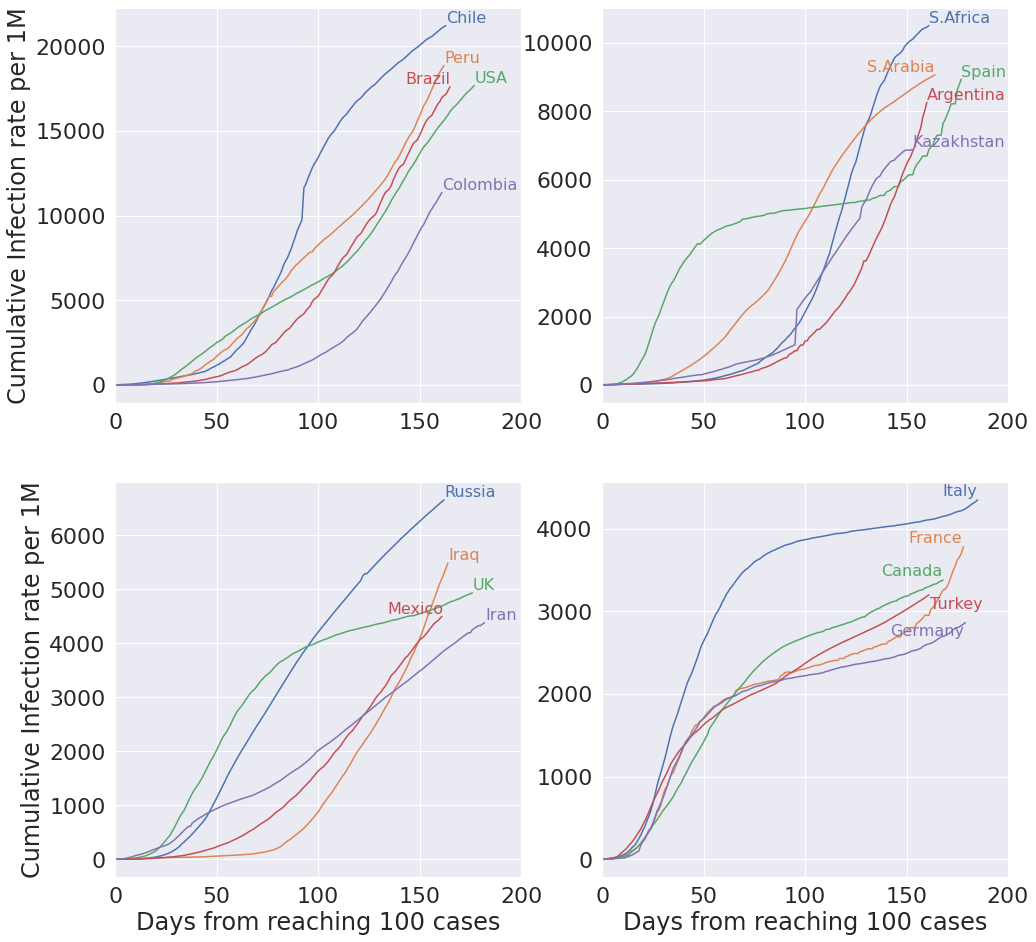

In [11]:
#Plotting the graph for infection rate per 1M
sns.set(rc={'figure.figsize':(16,16)}, font_scale = 2)
fig, axes = plt.subplots(2, 2)

sns.lineplot(x="Days_from_0", y="Cases_per_1m", hue="Countries", data=data_1_5, markers=True, hue_order=countries_1_5, legend=False, ax=axes[0, 0])
texts = [axes[0, 0].text(max_cases.loc[str(country)]['Days_from_0'], max_cases.loc[str(country)]['Cases_per_1m'], str(country), fontsize=16, color=axes[0, 0].get_lines()[countries_1_5.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_1_5]
adjust_text(texts)
axes[0, 0].set_ylabel("Cumulative Infection rate per 1M",fontsize=24)

sns.lineplot(x="Days_from_0", y="Cases_per_1m", hue="Countries", data=data_6_10, markers=True, hue_order=countries_6_10, legend=False, ax=axes[0, 1])
texts = [axes[0, 1].text(max_cases.loc[str(country)]['Days_from_0'], max_cases.loc[str(country)]['Cases_per_1m'], str(country), fontsize=16, color=axes[0, 1].get_lines()[countries_6_10.index(country)].get_c(), ha = 'left', va = 'top') for country in countries_6_10]
adjust_text(texts)

sns.lineplot(x="Days_from_0", y="Cases_per_1m", hue="Countries", data=data_11_15, markers=True, hue_order=countries_11_15, legend=False, ax=axes[1, 0])
texts = [axes[1, 0].text(max_cases.loc[str(country)]['Days_from_0'], max_cases.loc[str(country)]['Cases_per_1m'], str(country), fontsize=16, color=axes[1, 0].get_lines()[countries_11_15.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_11_15]
adjust_text(texts)
axes[1, 0].set_ylabel("Cumulative Infection rate per 1M",fontsize=24)
axes[1, 0].set_xlabel("Days from reaching 100 cases",fontsize=24)

sns.lineplot(x="Days_from_0", y="Cases_per_1m", hue="Countries", data=data_16_20, markers=True, hue_order=countries_16_20, legend=False, ax=axes[1, 1])
texts = [axes[1, 1].text(max_cases.loc[str(country)]['Days_from_0'], max_cases.loc[str(country)]['Cases_per_1m'], str(country), fontsize=16, color=axes[1, 1].get_lines()[countries_16_20.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_16_20]
adjust_text(texts)
axes[1, 1].set_xlabel("Days from reaching 100 cases",fontsize=24)

axes[0, 1].set_ylabel("",fontsize=24)
axes[1, 1].set_ylabel("",fontsize=24)
axes[0, 0].set_xlabel("",fontsize=24)
axes[0, 1].set_xlabel("",fontsize=24)
axes[0, 1].set_xlim([0, 200])
axes[1, 1].set_xlim([0, 200])
axes[0, 0].set_xlim([0, 200])
axes[1, 0].set_xlim([0, 200])
# axes[0, 0].set_yscale('log')
# axes[0, 1].set_yscale('log')
# axes[1, 0].set_yscale('log')
# axes[1, 1].set_yscale('log')

plt.savefig('Fig_2_1_Choudhary_Shreyas.png')